# Extract Largest Eigenvalue of Symmetric Matrix with a Neural Network

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import LatinHypercube
import os
from functools import partial

In [2]:
# Own implementations
%load_ext autoreload
%autoreload 2
from pinn import *

In [3]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [4]:
plt.style.use('../misc/report.mplstyle')

# Toggle to save plots as pdf
save=True
save_dir = "../../../tex/02_neural_nets_on_pdes/img/"

# Some shorthands for figure labels/legends
MSE = r"$\mathrm{MSE}_\mathcal{V}$"

In [5]:
# Double-precision by default
torch.set_default_dtype(torch.float32)

In [6]:
def power_iteration(A, N=100):
    eigenvector = np.random.rand(A.shape[0])
    for i in range(N):
        eigenvector = A @ eigenvector
        norm = np.linalg.norm(eigenvector)
        eigenvector /= norm
    return eigenvector

### Helper functions

In [7]:
def rejection_sampling(pdf, n=1000, xmin=0, xmax=.98):
    x=np.linspace(xmin,xmax,1000)  
    y=pdf(x)  
    pmin=0.  
    pmax=y.max()  
   
    naccept=0  
   
    ran=[] # output list of random numbers  
    while naccept<n:  
        x = (xmax - xmin) * np.random.rand(1) + xmin  
        y = (pmax - pmin) * np.random.rand(1) + pmin   
        
        if y<pdf(x):  
            ran.append(x)  
            naccept=naccept+1  
    
    return np.array(ran)  

def eigenvalue_of_eigenvector(x, A):
    return (x @ A @ x.T) / (x @ x.T)

### ODE specification

In [14]:
dim = 6
random_matrix=False
if random_matrix:
    A = generate_random_symmetric_matrix(dim).float()
else:
    #B = np.arange(36).reshape(dim,dim)
    #A = torch.tensor(1.0/np.linalg.norm(B) * (np.tril(B) + np.tril(B).T)).float()
    A = np.zeros((dim,dim))
    i,j = np.indices(A.shape)
    A[i == j] = 2
    A[i == j-1] = 1
    A[i == j+1] = 1
    A = torch.from_numpy(A).float()
assert np.allclose(A, A.T, rtol=1e-8, atol=1e-10)
print(f"A = {A}")

A = tensor([[2., 1., 0., 0., 0., 0.],
        [1., 2., 1., 0., 0., 0.],
        [0., 1., 2., 1., 0., 0.],
        [0., 0., 1., 2., 1., 0.],
        [0., 0., 0., 1., 2., 1.],
        [0., 0., 0., 0., 1., 2.]])


In [16]:
# Coordinate transformations to bring the infinite time domain t \in [0,inf) to tau \in [0,1)
def dtau_dt_inv_identity(tau):
    return torch.ones_like(tau)

def dtau_dt_inv_tan(tau):
    """
    Assuming t = tan(pi/2 * tau) this is (dtau/dt)^(-1)
    """
    return torch.pi/(2 * torch.cos(torch.pi/2 * tau)**2)

def dtau_dt_inv_arctanh(tau):
    """
    Assuming t = arctanh(tau) this is (dtau/dt)^(-1)
    """
    return 1.0/(1.0 - tau**2)

random_matrix = False

# Ordinary Differential Equation (parametrized on time tranformation and matrix)
class EigenODE:
    def __init__(self, A, dtau_dt_inv):
        self.domain_dim = 1
        self.target_dim = A.shape[-1]
        self.A = A
        self.dtau_dt_inv = dtau_dt_inv
        
    def __call__(self,y, tau):
        # Left hand side (LHS) of ODE
        y_tau = derivative(y, tau)
        # Right hand side (RHS) of ODE
        first_term = (y[:,None,:] @ (y[:,None,:] @ y[:,:,None] * self.A)).squeeze()
        second_term = (y[:,None,:] @ self.A @ y[:,:,None] @ y[:,None,:]).squeeze()
        #Prefactor of LHS due to coordinate transformation
        return y_tau - self.dtau_dt_inv(tau) * (first_term - second_term), torch.zeros_like(y)     

# Initial Condition
def ic(y, tau):
    return y - ic.y0, torch.zeros_like(y)
ic.y0 = torch.rand(dim).reshape(1,-1)
ic.y0 /= torch.sqrt(ic.y0 @ ic.y0.T).item()

# We can interpret the conservation property (d/dtau (y@y.T) = 0) of the ODE as boundary condition (i.e. true for all t). 
# Note that we compare against a scalar property (the norm) and not a vector. Hence the difference in 
# the second return argument compared to ic() or eigenvector_ode()
def norm_conservation(y, tau):
    return torch.sqrt((y[:,None,:] @ y[:,:,None]).squeeze(-1)) - 1, torch.zeros_like(tau)

def noop(y, tau):
    return torch.zeros_like(y), torch.zeros_like(y)

# solution must adhere to the initial conditions explicitly
def manifest_ic(net_output, tau):
    return ic.y0 + tau * net_output

# solution is identical to network output
def idendity(net_output, tau):
    return net_output

ivp1 = EigenODE(A, dtau_dt_inv_identity)
ivp2 = EigenODE(A, dtau_dt_inv_arctanh)

ivp1_ode_bc_ic = ([ivp1, ic, norm_conservation],{"solution_structure":idendity})
ivp1_ode_bc = ([ivp1, noop, norm_conservation], {"solution_structure":manifest_ic})
ivp1_ode = ([ivp1, noop, noop], {"solution_structure":manifest_ic})

ivp2_ode_bc_ic = ([ivp2, ic, norm_conservation],{"solution_structure":idendity})
ivp2_ode_bc = ([ivp2, noop, norm_conservation], {"solution_structure":manifest_ic})
ivp2_ode = ([ivp2, noop, noop], {"solution_structure":manifest_ic})

### Generate Datasets

In [17]:
def temporal_sample(T, N_t, N_ic, N_bc, kind="lhs", function=dtau_dt_inv_identity):
    if kind == "lhs":
        sampler = lambda N: torch.from_numpy(T * LatinHypercube(1).random(n = N)).float()
    elif kind == "rejection":
        sampler = lambda N: torch.from_numpy(rejection_sampling(function, n=N, xmin=0.01*T, xmax=.99*T)).reshape(-1,1).float()
    
    #Interior points
    samples_t = sampler(N_t)
    
    # Initial condition
    samples_t_ic = torch.zeros((N_ic, 1))
    
    #Boundary conditions
    samples_t_bc = sampler(N_bc)
    
    return samples_t, \
           samples_t_ic, \
           samples_t_bc

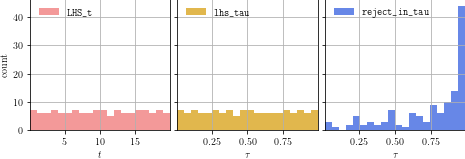

In [18]:
#IBVP parameters
N_interior =  2**7
N_bc = 2**7
N_ic = 2**7
T = 20
Tau = 1

# Generate training sets
lhs_in_t_train = temporal_sample(T, N_interior, N_ic, N_bc, kind="lhs")
lhs_in_tau_train = temporal_sample(Tau, N_interior, N_ic, N_bc, kind="lhs")
rejection_in_tau_train = temporal_sample(Tau, N_interior, N_ic, N_bc, kind="rejection", function=dtau_dt_inv_arctanh)

# Generate test data
lhs_in_t_test = temporal_sample(T, N_interior, N_ic, N_bc, kind="lhs")
lhs_in_tau_test = temporal_sample(Tau, N_interior, N_ic, N_bc, kind="lhs")
rejection_in_tau_test = temporal_sample(Tau, N_interior, N_ic, N_bc, kind="rejection", function=dtau_dt_inv_arctanh)

save=True
size = (3.9*2, 0.618 * 3.9) if save else (10,6)

fig, ax = plt.subplots(ncols = 3, figsize=size, sharey=True)
style = {
    "alpha":.8
}
colors = ["lightcoral", "goldenrod", "royalblue"]
labels = [r"$\texttt{LHS_t}$",r"$\texttt{lhs_tau}$",r"$\texttt{reject_in_tau}$"]
for i,ivp in enumerate([lhs_in_t_test, lhs_in_tau_test, rejection_in_tau_test]):
    t_int, _, _ = ivp
    ax[i].hist(t_int.numpy(), 20, **style, color=colors[i], label=labels[i])
    ax[i].legend(*ax[i].get_legend_handles_labels(), loc="upper left")
    
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$\mathrm{count}$")
ax[1].set_xlabel(r"$\tau$")
ax[2].set_xlabel(r"$\tau$")
plt.subplots_adjust(wspace=0.05, hspace=0)

if save:
    fig.savefig(save_dir + "eigenproblem_pinn_datasets.pdf",bbox_inches="tight",pad_inches = 0.02)
else:
    plt.show()

### Function Hooks used for training monitoring

In [19]:
def monitor_eigenvector_evolution(net):
    x = torch.tensor([1.]).reshape(1,1)
    coordinates = [
                    c.reshape(-1, 1) for c in torch.unbind(x, dim=-1)
    ]
    return trial_function(net(x), *coordinates).numpy()

def monitor_eigenvalue_evolution(net):
    return eigenvalue_of_eigenvector(monitor_eigenvector_evolution(net), A.numpy())

### Train the Network (Trial Run)

In [22]:
def early_convergence(loss):
    if np.abs(1.0 - loss / early_convergence.last_loss) < 1e-10:
        return True
    else:
        early_convergence.last_loss = loss
        return False
early_convergence.last_loss = np.inf
early_convergence.terminate = True

hp = {"optimizer_name":"lbfgs", 
      "optimizer_params":{"lr":1e-3}, 
      "hidden_layers":[30,30,30], 
      "activation_function": nn.Tanh(),
      "number_of_minibatches":1,
      "epochs":2000}

eigen_nn = PiNN(*ivp1_ode[0], **ivp1_ode[1],
                #hooks=[monitor_eigenvalue_evolution, monitor_eigenvector_evolution],
                events_for_loss=[early_convergence],
                verbose=True, hyperparameters=hp)
print(eigen_nn)
eigen_nn.fit(lhs_in_t_train)

NN(
  (ff_graph): Sequential(
    (0): Linear(in_features=1, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
  )
  (output): Linear(in_features=30, out_features=6, bias=True)
)
model parameters:                                                 2106
---------------------------Hyperparameters----------------------------
hidden_layers                                             [30, 30, 30]
activation_function                                             Tanh()
epochs                                                            2000
number_of_minibatches                                                1
optimizer_name                                                   lbfgs
optimizer_params                                         {'lr': 0.001}

-----------------------------Training Log-----------------------------
# of collocation points:           

## Hyperparameter Tuning

In [23]:
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest.basic_variant import BasicVariantGenerator

def no_increasing_loss(trial_id, result):
    if result["training_iteration"] == 1:
        no_increasing_loss.max_loss = result["validation_loss"]
        return False
    return result["validation_loss"] > no_increasing_loss.max_loss

parameter_space = {
    "layers": tune.randint(1, 4),
    "nodes": tune.randint(5,40),
    "activation_function": tune.choice([nn.Tanh(),nn.ReLU()]),
    "optimizer_name": tune.choice(["lbfgs","adam"]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "number_of_minibatches": 1
}
reasonable_start = [
    {
        "layers": 3,
        "nodes": 20,
        "activation_function": nn.Tanh(),
        "optimizer_name": "lbfgs",
        "lr": 1e-3,
    }
]

fixed_parameters = {
    "epochs": 1000
}

ivp_cost_function_datasets = [
    ("ivp1_ode_bc_ic_lhs", ivp1_ode_bc_ic, lhs_in_t_train, lhs_in_t_test),
    ("ivp1_ode_bc_lhs", ivp1_ode_bc, lhs_in_t_train, lhs_in_t_test),
    ("ivp1_ode_lhs", ivp1_ode, lhs_in_t_train, lhs_in_t_test),
    ("ivp2_ode_bc_ic_lhs", ivp2_ode_bc_ic, lhs_in_tau_train, lhs_in_tau_test),
    ("ivp2_ode_bc_lhs", ivp2_ode_bc, lhs_in_tau_train, lhs_in_tau_test),
    ("ivp2_ode_lhs", ivp2_ode, lhs_in_tau_train, lhs_in_tau_test),
    ("ivp2_ode_bc_ic_reject", ivp2_ode_bc_ic, rejection_in_tau_train, rejection_in_tau_test),
    ("ivp2_ode_bc_reject", ivp2_ode_bc, rejection_in_tau_train, rejection_in_tau_test),
    ("ivp2_ode_reject", ivp2_ode, rejection_in_tau_train, rejection_in_tau_test)
]
for name, ivp_cost, X_train, X_test in ivp_cost_function_datasets:
    eigen_nn = PiNN(*ivp_cost[0], **ivp_cost[1], hyperparameters=fixed_parameters)
    
    scheduler=ASHAScheduler(max_t=fixed_parameters["epochs"], grace_period=5, brackets=3)
    search_alg = BasicVariantGenerator(random_state=42)
    analysis = tune.run(tune.with_parameters(eigen_nn.train, X_train=X_train, X_test=X_test),
                        config=parameter_space,
                        num_samples=200,
                        max_failures=2,
                        metric="validation_loss",
                        mode="min",
                        search_alg=search_alg,
                        scheduler=scheduler,
                        stop=no_increasing_loss,
                        local_dir="../data/ray",
                        name=name,
                        resume=False,
                        verbose=1)

2022-04-27 19:09:11,272	INFO tune.py:701 -- Total run time: 121.96 seconds (121.74 seconds for the tuning loop).


### Hyperparameter Optimization for IVP1 (no time transformation, uniform sampling, various cost functions)

2022-04-27 19:10:06,077	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2022-04-27 19:10:06,352	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2022-04-27 19:10:06,650	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


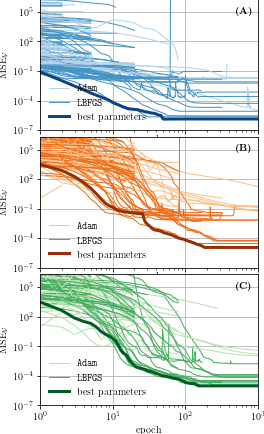

In [24]:
from ray.tune.analysis import ExperimentAnalysis

names = [ivp1_variations[0] for ivp1_variations in ivp_cost_function_datasets[:3]]
analyses = [ExperimentAnalysis("../data/ray/" + name) for name in names]
labels = [r"\textbf{(A)}",r"\textbf{(B)}",r"\textbf{(C)}"]
colors = ["Blues", "Oranges", "Greens"]

size = (3.9, 3.1 * 0.618 * 3.9) if save else (10,6)

fig, axs = plt.subplots(nrows=3, figsize=size, sharex=True)
    
for ax, analysis, label, color in zip(axs, analyses, labels, colors):
    ax.set_xscale("log")
    ax.set_yscale("log")
        
    dfs = analysis.trial_dataframes
    best_df = dfs[analysis.get_best_logdir("validation_loss", "min")]
    best_cfg = analysis.get_best_logdir("validation_loss", "min")

    blues = sns.color_palette(color,12)

    for k,d in dfs.items():
        if "adam" in k:
            line_adam, = ax.plot(d.training_iteration, d.validation_loss, color=blues[3], lw=1)
        else:
            line_lbfgs, = ax.plot(d.training_iteration, d.validation_loss, color=blues[7], lw=1)
        
    ax.plot(best_df.training_iteration, best_df.validation_loss, color=blues[11], lw=3, label=r"best parameters")
    line_adam.set_label(rf"\texttt{{Adam}}")
    line_lbfgs.set_label(rf"\texttt{{LBFGS}}")
    ax.set_ylim([1e-7,2e6])
    ax.set_xlabel(r"epoch")
    ax.set_ylabel(MSE)
    
    handles, labels = ax.get_legend_handles_labels()
    labels = np.array(labels)
    handles = np.array(handles)
    permutation = np.argsort(labels)
    labels = labels[permutation]
    handles = handles[permutation]
    ax.legend(handles, labels, loc="lower left")
    ax.text(0.98, 0.95, label, transform=ax.transAxes, ha="right", va="top")
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
if save:
    fig.savefig(save_dir + "eigenproblem_hyperopt_ivp1.pdf",bbox_inches="tight",pad_inches = 0.02)
else:
    plt.show()

### Comparison of Best Hyperparameter combinations across IVP1-3

2022-04-27 19:10:58,002	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2022-04-27 19:10:58,231	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2022-04-27 19:10:58,461	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2022-04-27 19:10:58,830	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2022-04-27 19:10:59,100	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is 

['ODE + norm + IC', 'ODE + norm', 'ODE', 'ODE + norm + IC', 'ODE + norm', 'ODE']


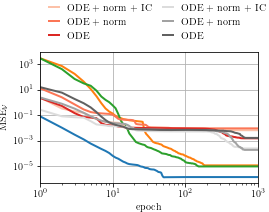

In [25]:
names_ivp1 = [ivp1_variations[0] for ivp1_variations in ivp_cost_function_datasets[:3]]
analyses_ivp1 = [ExperimentAnalysis("../data/ray/" + name) for name in names_ivp1]

names_ivp21 = [ivp21_variations[0] for ivp21_variations in ivp_cost_function_datasets[3:6]]
analyses_ivp21 = [ExperimentAnalysis("../data/ray/" + name) for name in names_ivp21]

names_ivp22 = [ivp22_variations[0] for ivp22_variations in ivp_cost_function_datasets[6:9]]
analyses_ivp22 = [ExperimentAnalysis("../data/ray/" + name) for name in names_ivp22]

size = (3.9, 0.618 * 3.9) if save else (10,6)

fig, ax = plt.subplots(figsize=size)
ax.set_xscale("log")
ax.set_yscale("log")
for analysis, in zip(analyses_ivp1):
    dfs = analysis.trial_dataframes
    best_df = dfs[analysis.get_best_logdir("validation_loss", "min")]
    ax.plot(best_df.training_iteration, best_df.validation_loss)
    
colors = sns.color_palette("Reds",12)
labels = [r"ODE + norm + IC",r"ODE + norm",r"ODE"]
for i,analysis in enumerate(analyses_ivp21):
    dfs = analysis.trial_dataframes
    best_df = dfs[analysis.get_best_logdir("validation_loss", "min")]
    ax.plot(best_df.training_iteration, best_df.validation_loss, color=colors[2 + 3*i], label=labels[i])

colors = sns.color_palette("Greys",12)
for i,analysis in enumerate(analyses_ivp22):
    dfs = analysis.trial_dataframes
    best_df = dfs[analysis.get_best_logdir("validation_loss", "min")]
    ax.plot(best_df.training_iteration, best_df.validation_loss, color=colors[2 + 3*i], label=labels[i])
handles, labels = ax.get_legend_handles_labels()
print(labels)
leg = plt.legend(handles, labels, 
                 ncol=2,bbox_to_anchor=(0, 1.02, 1., .102), 
                 columnspacing=1.2,
                 handlelength=1,
                 loc='lower left')
        
ax.set_xlabel(r"epoch")
ax.set_ylabel(MSE)

if save:
    fig.savefig(save_dir + "eigenproblem_hyperopt_all_best.pdf",bbox_inches="tight",pad_inches = 0.02)
else:
    plt.show()

### Comparison between PiNN and Numpy

Sp(A) = [3.8019378  3.2469797  2.445042   1.5549581  0.7530204  0.19806227]
max{ Sp(A) } = 3.8019378185272217
eigenvector = [-0.23192061 -0.4179065   0.5211209   0.5211209   0.4179065   0.23192061]


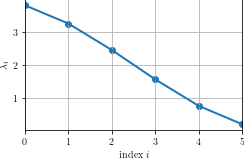

In [26]:
#Ground Truth
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Sort in descending order
permutation = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[permutation]
eigenvectors = eigenvectors[permutation]
print(f"Sp(A) = {eigenvalues}")
print(f"max{{ Sp(A) }} = {np.max(eigenvalues)}")
print(f"eigenvector = {eigenvectors[0]}")

size = (3.9, 0.618 * 3.9) if save else (10,6)

fig, ax = plt.subplots(figsize=size)

idx = np.arange(dim)
ax.plot(idx, eigenvalues)
ax.scatter(idx, eigenvalues)

ax.set_xlabel(r"index $i$")
ax.set_ylabel("$\lambda_i$")
if save:
    fig.savefig(save_dir + "eigenproblem_true_spectrum.pdf",bbox_inches="tight",pad_inches = 0.02)
else:
    plt.show()

In [28]:
from tabulate import tabulate

table = [[r"ODE + norm + IC"],[r"ODE + norm"],[r"ODE"]]
name_to_label = {
    "ivp1_ode_bc_ic_lhs":r"ODE + norm + IC",
    "ivp1_ode_bc_lhs":r"ODE + norm",
    "ivp1_ode_lhs":r"ODE",
    "ivp2_ode_bc_ic_lhs":r"ODE + norm + IC",
    "ivp2_ode_bc_lhs":r"ODE + norm",
    "ivp2_ode_lhs":r"ODE",
    "ivp2_ode_bc_ic_reject":r"ODE + norm + IC",
    "ivp2_ode_bc_reject":r"ODE + norm",
    "ivp2_ode_reject":r"ODE"
}
label_to_idx = {
    r"ODE + norm + IC":0,
    r"ODE + norm":1,
    r"ODE":2,
}
labels_ivp = [r"IVP$(t \sim \mathcal{U}(0,20))$",r"  IVP$(\tau \sim \mathcal{U}(0,1))$",r"IVP$(\tau \sim \arctanh)$"]
for experiment in ivp_cost_function_datasets:
    name, ivp_cost, _, X_test = experiment
    analysis = ExperimentAnalysis("../data/ray/" + name) 
    best_cfg = analysis.get_best_config("validation_loss", "min")
    logdir = analysis.get_best_logdir("validation_loss", "min")
    best_cfg["hidden_layers"] = best_cfg["layers"] * [best_cfg["nodes"]]
    best_cfg["optimizer_params"] = {"lr":best_cfg["lr"]}
    best_cfg = best_cfg | fixed_parameters
    state_dict = torch.load(os.path.join(logdir, "model.pth"))
    best_eigen_nn = PiNN(*ivp_cost[0], **ivp_cost[1],
                hyperparameters=best_cfg, verbose=False)
    best_eigen_nn.net.load_state_dict(state_dict)
    final_time = T if "ivp1" in name else Tau
    x = best_eigen_nn.predict(torch.tensor([float(final_time)]).reshape(1,1))
    ev_from_network = eigenvalue_of_eigenvector(x, A.numpy()).item()  
    error = np.abs(np.max(eigenvalues) - ev_from_network)/np.max(eigenvalues)
    table[label_to_idx[name_to_label[name]]].append(f"$\lambda = {ev_from_network:.6f}, \epsilon_\lambda={100 * error:.4f}\%$")
    

print(tabulate(table, headers = labels_ivp, tablefmt="pretty"))

2022-04-27 19:12:46,801	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2022-04-27 19:12:47,030	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2022-04-27 19:12:47,275	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2022-04-27 19:12:47,713	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2022-04-27 19:12:47,953	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is 

+-----------------+-------------------------------------------------+-------------------------------------------------+-------------------------------------------------+
|                 |         IVP$(t \sim \mathcal{U}(0,20))$         |         IVP$(\tau \sim \mathcal{U}(0,1))$       |            IVP$(\tau \sim \arctanh)$            |
+-----------------+-------------------------------------------------+-------------------------------------------------+-------------------------------------------------+
| ODE + norm + IC | $\lambda = 3.801937, \epsilon_\lambda=0.0000\%$ | $\lambda = 3.801921, \epsilon_\lambda=0.0004\%$ | $\lambda = 3.799323, \epsilon_\lambda=0.0688\%$ |
|   ODE + norm    | $\lambda = 3.801911, \epsilon_\lambda=0.0007\%$ | $\lambda = 3.801901, \epsilon_\lambda=0.0010\%$ | $\lambda = 3.799516, \epsilon_\lambda=0.0637\%$ |
|       ODE       | $\lambda = 3.801928, \epsilon_\lambda=0.0003\%$ | $\lambda = 3.800951, \epsilon_\lambda=0.0260\%$ | $\lambda = 3.799924, \epsilon_

In [31]:
import numbers 

def format_numbers(n):
    if type(n) is int:
        return f"${n}$"
    else:
        return f"${n:.5f}$"
    
name = "ivp2_ode_bc_ic_lhs"
analysis = ExperimentAnalysis("../data/ray/" + name) 
best_ev_cfg = analysis.get_best_config("validation_loss", "min")
logdir = analysis.get_best_logdir("validation_loss", "min")
state_dict = torch.load(os.path.join(logdir, "model.pth"))
name, ivp_cost , _, X_test = ivp_cost_function_datasets[3]

#best_ev_cfg["hidden_layers"] = best_ev_cfg["layers"] * [best_ev_cfg["nodes"]]
#best_ev_cfg["optimizer_params"] = {"lr":best_ev_cfg["lr"]}
best_ev_cfg = best_ev_cfg | fixed_parameters

best_ev_hp = [[rf"\texttt{{{k}}}", rf"\texttt{{{v}}}" if not isinstance(v, numbers.Number) else format_numbers(v)] for k, v in best_ev_cfg.items()]
print(tabulate(best_ev_hp, tablefmt="latex_raw"))

2022-04-27 19:15:11,233	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


\begin{tabular}{ll}
\hline
 \texttt{layers}                & $1$             \\
 \texttt{nodes}                 & $29$            \\
 \texttt{activation_function}   & \texttt{Tanh()} \\
 \texttt{optimizer_name}        & \texttt{lbfgs}  \\
 \texttt{lr}                    & $0.08450$       \\
 \texttt{number_of_minibatches} & $1$             \\
 \texttt{epochs}                & $1000$          \\
\hline
\end{tabular}
